In [260]:
import numpy as np

c1 = 0.7
c2 = 1
w = 0.9

def fit_func(x):
    return np.clip(100-x[0]**2, 0, 100)

its = 1000
n_particals = 10
dims = 1

particals_pos = []
particals_vel = []

for i in range(n_particals):
    particals_pos_i = np.random.normal(-10, 10, dims)
    particals_vel_i = np.random.normal(-10, 10, dims)
    particals_vel.append(particals_vel_i)
    particals_pos.append(particals_pos_i)
    
particals_pos = np.array(particals_pos)
particals_vel = np.array(particals_vel)

particals = np.array([particals_pos, particals_vel])

particals_fit = np.zeros(len(particals_pos))
for i in range(len(particals_pos)):
    particals_fit[i] = fit_func(particals_pos[i])


global_fit = np.max(particals_fit)
ans = [global_fit]
for i in range(len(particals_fit)):
    if particals_fit[i] == global_fit:
        ans.append(particals[:1,i,:])
ans = np.array(ans, dtype=object)
for i in range(its):
    for j in range(len(particals[0])):
        r1 = np.random.normal(-1,1,len(particals[1,j]))
        r2 = np.random.normal(-1,1,len(particals[1,j]))
        particals[1,j] = particals[1,j] * w + c1 * (particals_fit[j] - fit_func(particals[0,j])) * r1 + c2 * (global_fit - fit_func(particals[0,j]))
        particals[0,j] = particals[0,j] + particals[1,j]
    #print(particals_fit)
    particals_fit = np.zeros(len(particals_pos))
    for i in range(len(particals_pos)):
        particals_fit[i] = fit_func(particals[0,i])

    global_fit = np.max(particals_fit)
    if global_fit >= ans[0] :
        ans[0] = global_fit
        for i in range(len(particals_fit)):
            if particals_fit[i] == global_fit:
                ans[1] = particals[:1,i,:]
                
print(ans[1])

[[-70.90470173]]


In [1]:
from functools import partial
import numpy as np

def _obj_wrapper(func, args, kwargs, x):
    return func(x, *args, **kwargs)

def _is_feasible_wrapper(func, x):
    return np.all(func(x)>=0)

def _cons_none_wrapper(x):
    return np.array([0])

def _cons_ieqcons_wrapper(ieqcons, args, kwargs, x):
    return np.array([y(x, *args, **kwargs) for y in ieqcons])

def _cons_f_ieqcons_wrapper(f_ieqcons, args, kwargs, x):
    return np.array(f_ieqcons(x, *args, **kwargs))
    
def pso(func, lb, ub, ieqcons=[], f_ieqcons=None, args=(), kwargs={}, 
        swarmsize=100, omega=0.5, phip=0.5, phig=0.5, maxiter=100, 
        minstep=1e-8, minfunc=1e-8, debug=False, processes=1,
        particle_output=False):
    """
    Perform a particle swarm optimization (PSO)
   
    Parameters
    ==========
    func : function
        The function to be minimized
    lb : array
        The lower bounds of the design variable(s)
    ub : array
        The upper bounds of the design variable(s)
   
    Optional
    ========
    ieqcons : list
        A list of functions of length n such that ieqcons[j](x,*args) >= 0.0 in 
        a successfully optimized problem (Default: [])
    f_ieqcons : function
        Returns a 1-D array in which each element must be greater or equal 
        to 0.0 in a successfully optimized problem. If f_ieqcons is specified, 
        ieqcons is ignored (Default: None)
    args : tuple
        Additional arguments passed to objective and constraint functions
        (Default: empty tuple)
    kwargs : dict
        Additional keyword arguments passed to objective and constraint 
        functions (Default: empty dict)
    swarmsize : int
        The number of particles in the swarm (Default: 100)
    omega : scalar
        Particle velocity scaling factor (Default: 0.5)
    phip : scalar
        Scaling factor to search away from the particle's best known position
        (Default: 0.5)
    phig : scalar
        Scaling factor to search away from the swarm's best known position
        (Default: 0.5)
    maxiter : int
        The maximum number of iterations for the swarm to search (Default: 100)
    minstep : scalar
        The minimum stepsize of swarm's best position before the search
        terminates (Default: 1e-8)
    minfunc : scalar
        The minimum change of swarm's best objective value before the search
        terminates (Default: 1e-8)
    debug : boolean
        If True, progress statements will be displayed every iteration
        (Default: False)
    processes : int
        The number of processes to use to evaluate objective function and 
        constraints (default: 1)
    particle_output : boolean
        Whether to include the best per-particle position and the objective
        values at those.
   
    Returns
    =======
    g : array
        The swarm's best known position (optimal design)
    f : scalar
        The objective value at ``g``
    p : array
        The best known position per particle
    pf: arrray
        The objective values at each position in p
   
    """
   
    assert len(lb)==len(ub), 'Lower- and upper-bounds must be the same length'
    assert hasattr(func, '__call__'), 'Invalid function handle'
    lb = np.array(lb)
    ub = np.array(ub)
    assert np.all(ub>lb), 'All upper-bound values must be greater than lower-bound values'
   
    vhigh = np.abs(ub - lb)
    vlow = -vhigh

    # Initialize objective function
    obj = partial(_obj_wrapper, func, args, kwargs)
    
    # Check for constraint function(s) #########################################
    if f_ieqcons is None:
        if not len(ieqcons):
            if debug:
                print('No constraints given.')
            cons = _cons_none_wrapper
        else:
            if debug:
                print('Converting ieqcons to a single constraint function')
            cons = partial(_cons_ieqcons_wrapper, ieqcons, args, kwargs)
    else:
        if debug:
            print('Single constraint function given in f_ieqcons')
        cons = partial(_cons_f_ieqcons_wrapper, f_ieqcons, args, kwargs)
    is_feasible = partial(_is_feasible_wrapper, cons)

    # Initialize the multiprocessing module if necessary
    if processes > 1:
        import multiprocessing
        mp_pool = multiprocessing.Pool(processes)
        
    # Initialize the particle swarm ############################################
    S = swarmsize
    D = len(lb)  # the number of dimensions each particle has
    x = np.random.rand(S, D)  # particle positions
    v = np.zeros_like(x)  # particle velocities
    p = np.zeros_like(x)  # best particle positions
    fx = np.zeros(S)  # current particle function values
    fs = np.zeros(S, dtype=bool)  # feasibility of each particle
    fp = np.ones(S)*np.inf  # best particle function values
    g = []  # best swarm position
    fg = np.inf  # best swarm position starting value
    
    # Initialize the particle's position
    x = lb + x*(ub - lb)

    # Calculate objective and constraints for each particle
    if processes > 1:
        fx = np.array(mp_pool.map(obj, x))
        fs = np.array(mp_pool.map(is_feasible, x))
    else:
        for i in range(S):
            fx[i] = obj(x[i, :])
            fs[i] = is_feasible(x[i, :])
       
    # Store particle's best position (if constraints are satisfied)
    i_update = np.logical_and((fx < fp), fs)
    p[i_update, :] = x[i_update, :].copy()
    fp[i_update] = fx[i_update]

    # Update swarm's best position
    i_min = np.argmin(fp)
    if fp[i_min] < fg:
        fg = fp[i_min]
        g = p[i_min, :].copy()
    else:
        # At the start, there may not be any feasible starting point, so just
        # give it a temporary "best" point since it's likely to change
        g = x[0, :].copy()
       
    # Initialize the particle's velocity
    v = vlow + np.random.rand(S, D)*(vhigh - vlow)
       
    # Iterate until termination criterion met ##################################
    it = 1
    while it <= maxiter:
        rp = np.random.uniform(size=(S, D))
        rg = np.random.uniform(size=(S, D))

        # Update the particles velocities
        v = omega*v + phip*rp*(p - x) + phig*rg*(g - x)
        # Update the particles' positions
        x = x + v
        # Correct for bound violations
        maskl = x < lb
        masku = x > ub
        x = x*(~np.logical_or(maskl, masku)) + lb*maskl + ub*masku

        # Update objectives and constraints
        if processes > 1:
            fx = np.array(mp_pool.map(obj, x))
            fs = np.array(mp_pool.map(is_feasible, x))
        else:
            for i in range(S):
                fx[i] = obj(x[i, :])
                fs[i] = is_feasible(x[i, :])

        # Store particle's best position (if constraints are satisfied)
        i_update = np.logical_and((fx < fp), fs)
        p[i_update, :] = x[i_update, :].copy()
        fp[i_update] = fx[i_update]

        # Compare swarm's best position with global best position
        i_min = np.argmin(fp)
        if fp[i_min] < fg:
            if debug:
                print('New best for swarm at iteration {:}: {:} {:}'\
                    .format(it, p[i_min, :], fp[i_min]))

            p_min = p[i_min, :].copy()
            stepsize = np.sqrt(np.sum((g - p_min)**2))

            if np.abs(fg - fp[i_min]) <= minfunc:
                print('Stopping search: Swarm best objective change less than {:}'\
                    .format(minfunc))
                if particle_output:
                    return p_min, fp[i_min], p, fp
                else:
                    return p_min, fp[i_min]
            elif stepsize <= minstep:
                print('Stopping search: Swarm best position change less than {:}'\
                    .format(minstep))
                if particle_output:
                    return p_min, fp[i_min], p, fp
                else:
                    return p_min, fp[i_min]
            else:
                g = p_min.copy()
                fg = fp[i_min]

        if debug:
            print('Best after iteration {:}: {:} {:}'.format(it, g, fg))
        it += 1

    print('Stopping search: maximum iterations reached --> {:}'.format(maxiter))
    
    if not is_feasible(g):
        print("However, the optimization couldn't find a feasible design. Sorry")
    if particle_output:
        return g, fg, p, fp
    else:
        return g, fg
 

In [2]:

def objective(x):
    return x[0]**2 + x[1]**2  # пример функции для минимизации

lb = [-10, -10]  # нижние границы
ub = [10, 10]    # верхние границы

xopt, fopt = pso(objective, lb, ub, swarmsize=30, maxiter=100)
print(f"Оптимальное решение: {xopt}, значение функции: {fopt}")


Stopping search: Swarm best objective change less than 1e-08
Оптимальное решение: [-6.48084068e-05 -4.05911953e-05], значение функции: 5.847774727333679e-09


In [ ]:
import numpy as np
import EFIE as solve
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12

frequency = 1e6 * 146
omega, wavelength = 2 * np.pi * frequency, light_speed / frequency
incident_field, radius = 220, 3.175e-3
delta_r = wavelength / 200

class yagi:
    def __init__(self, position, angle, length, source_position, radius):
        self.position = position
        self.angle = angle
        self.length = length
        self.source_position = source_position
        self.radius = radius

class tree:
    def __init__(self, its, phi, length, f, radius, field):
        self.its = its
        self.phi = phi
        self.length = length
        self.f = f
        self.radius = radius
        self.field = field

structure_type = 'tree'
basis_functions = 'triangle'
its = 3
length = wavelength/10
f = 1
radius = 3.175e-3
field = incident_field

def objective(phi):
    tree_test = tree(its,phi,length,f,radius,field)
    I,R = solve.calc_current_amplitudes(structure_type, basis_functions, tree_test, frequency, delta_r)
    E,angles = solve.calc_field_pattern(0,0,basis_functions,structure_type,tree_test,I,R,delta_r,frequency)
    E = E / np.max(E)
    aim_func = np.zeros(len(angles))
    for i in range(len(angles)):
        aim_func[i] = max(0, np.sin(angles[i])**7)
        E[i] = E[i] / np.max(E)
    fit = 1 - np.dot(E,aim_func) / np.linalg.norm(E) / np.linalg.norm(aim_func)
    print(fit)
    return fit

lb = np.full(2 * (2 ** its - 1), 0.0)
ub = np.full(2 * (2 ** its - 1), np.pi/2)

xopt, fopt = pso(objective, lb, ub, swarmsize=10, maxiter=20)
print(f"Оптимальное решение: {xopt}, значение функции: {fopt}")


100%|██████████| 15/15 [01:15<00:00,  5.00s/it]


0.5590283804663063


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.5526151340593835


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.46415747732698065


100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


0.5471133158072423


100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


0.5024409688784013


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.38283987291883803


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.500731733703387


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.5219298421655798


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.574694143260594


100%|██████████| 15/15 [01:15<00:00,  5.03s/it]


0.6157832513428751


100%|██████████| 15/15 [01:15<00:00,  5.03s/it]


0.5137597971046342


100%|██████████| 15/15 [01:15<00:00,  5.00s/it]


0.41109141941772254


100%|██████████| 15/15 [01:11<00:00,  4.79s/it]


0.5498742012530264


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.44646399491688005


100%|██████████| 15/15 [01:11<00:00,  4.79s/it]


0.5442388033776676


100%|██████████| 15/15 [01:06<00:00,  4.45s/it]


0.3755156793829031


100%|██████████| 15/15 [01:11<00:00,  4.74s/it]


0.5197012649806343


100%|██████████| 15/15 [01:11<00:00,  4.75s/it]


0.5043460011727345


100%|██████████| 15/15 [01:05<00:00,  4.35s/it]


0.380844691522472


100%|██████████| 15/15 [01:13<00:00,  4.93s/it]


0.5167387271204957


100%|██████████| 15/15 [01:05<00:00,  4.39s/it]


0.42223759302754915


100%|██████████| 15/15 [01:06<00:00,  4.45s/it]


0.34111020207693277


100%|██████████| 15/15 [01:11<00:00,  4.76s/it]


0.5107688138193347


100%|██████████| 15/15 [01:09<00:00,  4.66s/it]


0.474472277343042


100%|██████████| 15/15 [01:12<00:00,  4.80s/it]


0.5713539908066447


100%|██████████| 15/15 [01:03<00:00,  4.24s/it]


0.45737892759174437


100%|██████████| 15/15 [01:11<00:00,  4.75s/it]


0.5106992843905535


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.5053309657362117


100%|██████████| 15/15 [01:07<00:00,  4.49s/it]


0.440328435598504


100%|██████████| 15/15 [01:15<00:00,  5.02s/it]


0.5253113788314792


100%|██████████| 15/15 [01:09<00:00,  4.66s/it]


0.4353701085908461


100%|██████████| 15/15 [01:06<00:00,  4.42s/it]


0.39582311354229294


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.5387065320012532


100%|██████████| 15/15 [01:10<00:00,  4.67s/it]


0.47474712991148516


100%|██████████| 15/15 [01:11<00:00,  4.75s/it]


0.5286935793923372


100%|██████████| 15/15 [01:06<00:00,  4.42s/it]


0.45875819188029454


100%|██████████| 15/15 [01:11<00:00,  4.73s/it]


0.5095280065254504


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.5139847287887305


100%|██████████| 15/15 [01:10<00:00,  4.67s/it]


0.4216898506985691


100%|██████████| 15/15 [01:13<00:00,  4.92s/it]


0.6048996638340012


100%|██████████| 15/15 [01:09<00:00,  4.62s/it]


0.40985831731276334


100%|██████████| 15/15 [01:05<00:00,  4.40s/it]


0.35057594617069565


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.5601084471064129


100%|██████████| 15/15 [01:09<00:00,  4.66s/it]


0.46394262769545414


100%|██████████| 15/15 [01:11<00:00,  4.79s/it]


0.5220573190916733


100%|██████████| 15/15 [01:06<00:00,  4.46s/it]


0.33954567723539564


100%|██████████| 15/15 [01:11<00:00,  4.77s/it]


0.5390989819078909


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.514640588311334


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.5602068266542772


100%|██████████| 15/15 [01:08<00:00,  4.57s/it]


0.4187282403541813


100%|██████████| 15/15 [01:09<00:00,  4.66s/it]


0.39448706611030604


100%|██████████| 15/15 [01:06<00:00,  4.46s/it]


0.321987211656497


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.5289121276779098


100%|██████████| 15/15 [01:09<00:00,  4.65s/it]


0.4689580324397218


100%|██████████| 15/15 [01:14<00:00,  5.00s/it]


0.5122447848750704


100%|██████████| 15/15 [01:05<00:00,  4.39s/it]


0.3311288006324806


100%|██████████| 15/15 [01:11<00:00,  4.76s/it]


0.5364582167702772


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.5369871073245583


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.5956633377402574


100%|██████████| 15/15 [01:09<00:00,  4.66s/it]


0.42063315204187646


100%|██████████| 15/15 [01:09<00:00,  4.66s/it]


0.3382758458560289


100%|██████████| 15/15 [01:06<00:00,  4.43s/it]


0.31831343390090283


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.5216636420421668


100%|██████████| 15/15 [01:09<00:00,  4.63s/it]


0.4674257357377595


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.5107722373401784


100%|██████████| 15/15 [01:05<00:00,  4.39s/it]


0.34321535989365626


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.5469189673774527


100%|██████████| 15/15 [01:15<00:00,  5.00s/it]


0.5192836178204125


100%|██████████| 15/15 [01:14<00:00,  5.00s/it]


0.5964454979712288


100%|██████████| 15/15 [01:06<00:00,  4.44s/it]


0.43374613484943425


100%|██████████| 15/15 [01:04<00:00,  4.29s/it]


0.44711635814712014


100%|██████████| 15/15 [01:06<00:00,  4.43s/it]


0.31841826961555064


100%|██████████| 15/15 [01:15<00:00,  5.01s/it]


0.5280979999608686


100%|██████████| 15/15 [01:09<00:00,  4.64s/it]


0.4709471820088702


100%|██████████| 15/15 [01:14<00:00,  5.00s/it]


0.5335317894295786


100%|██████████| 15/15 [01:06<00:00,  4.46s/it]


0.3372925115653669


100%|██████████| 15/15 [01:15<00:00,  5.00s/it]


0.5578947046249848


100%|██████████| 15/15 [01:15<00:00,  5.01s/it]


0.529224575137998


100%|██████████| 15/15 [01:15<00:00,  5.00s/it]


0.5628860989913672


100%|██████████| 15/15 [01:09<00:00,  4.63s/it]


0.42251812902160746


100%|██████████| 15/15 [01:04<00:00,  4.29s/it]


0.4461055292498145


100%|██████████| 15/15 [01:06<00:00,  4.41s/it]


0.3184917819900831


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.5292363564685376


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.472260165265598


100%|██████████| 15/15 [01:15<00:00,  5.00s/it]


0.5721123829348564


100%|██████████| 15/15 [01:06<00:00,  4.43s/it]


0.32419999846651504


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.5579499485910799


100%|██████████| 15/15 [01:15<00:00,  5.02s/it]


0.5436110571442067


100%|██████████| 15/15 [01:14<00:00,  4.95s/it]


0.5721731038209299


100%|██████████| 15/15 [01:09<00:00,  4.65s/it]


0.3903341030761259


100%|██████████| 15/15 [01:09<00:00,  4.66s/it]


0.43342843790598173


100%|██████████| 15/15 [01:06<00:00,  4.43s/it]


0.31823210348768605


100%|██████████| 15/15 [01:15<00:00,  5.01s/it]


0.5479267394581229


100%|██████████| 15/15 [01:14<00:00,  5.00s/it]


0.4552033464014389


100%|██████████| 15/15 [01:09<00:00,  4.64s/it]


0.4025417826924619


100%|██████████| 15/15 [01:06<00:00,  4.43s/it]


0.31867277239915737


100%|██████████| 15/15 [01:15<00:00,  5.03s/it]


0.5386300669255202


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.544351609994771


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.552173727239482


100%|██████████| 15/15 [01:09<00:00,  4.65s/it]


0.34502032561138585


100%|██████████| 15/15 [01:09<00:00,  4.62s/it]


0.31978682406811787


100%|██████████| 15/15 [01:06<00:00,  4.45s/it]


0.3181931551294853


100%|██████████| 15/15 [01:15<00:00,  5.02s/it]


0.5735858795903249


100%|██████████| 15/15 [01:15<00:00,  5.00s/it]


0.4726132089934898


100%|██████████| 15/15 [01:09<00:00,  4.66s/it]


0.40181485038375164


100%|██████████| 15/15 [01:06<00:00,  4.44s/it]


0.3184934363156444


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.5312115722928592


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.5587144442041878


100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


0.5432883254797072


100%|██████████| 15/15 [01:09<00:00,  4.64s/it]


0.32613611764000927


100%|██████████| 15/15 [01:09<00:00,  4.65s/it]


0.33397465459232467


100%|██████████| 15/15 [01:06<00:00,  4.42s/it]


0.31819861812147354


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.5279885687725829


100%|██████████| 15/15 [01:15<00:00,  5.00s/it]


0.450957590076291


100%|██████████| 15/15 [01:09<00:00,  4.64s/it]


0.39038065571310077


100%|██████████| 15/15 [01:06<00:00,  4.45s/it]


0.3191098896912764


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.5188074997542222


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.5455993341385184


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.5827016352322065


100%|██████████| 15/15 [01:10<00:00,  4.67s/it]


0.3240197135855909


100%|██████████| 15/15 [01:09<00:00,  4.66s/it]


0.33717528609687397


100%|██████████| 15/15 [01:06<00:00,  4.44s/it]


0.3182178734950061


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.5091082488669708


100%|██████████| 15/15 [01:14<00:00,  5.00s/it]


0.4513669985548724


100%|██████████| 15/15 [01:10<00:00,  4.67s/it]


0.3219998008741255


100%|██████████| 15/15 [01:06<00:00,  4.46s/it]


0.31854371232523604


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.503077948821488


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.5430322748667424


100%|██████████| 15/15 [01:15<00:00,  5.01s/it]


0.5724260807873852


100%|██████████| 15/15 [01:09<00:00,  4.63s/it]


0.3224314680817517


100%|██████████| 15/15 [01:09<00:00,  4.66s/it]


0.3279225022759503


100%|██████████| 15/15 [01:06<00:00,  4.47s/it]


0.3181972254591533


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.5036134905606626


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.46119919152319877


100%|██████████| 15/15 [01:09<00:00,  4.64s/it]


0.4434949255007188


100%|██████████| 15/15 [01:06<00:00,  4.42s/it]


0.3181648695204049


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.50236097336542


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.5451261238966416


100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


0.5247034935361896


100%|██████████| 15/15 [01:06<00:00,  4.46s/it]


0.32218019353264626


100%|██████████| 15/15 [01:10<00:00,  4.69s/it]


0.318501441959505


100%|██████████| 15/15 [01:06<00:00,  4.46s/it]


0.3181581910230339


100%|██████████| 15/15 [01:15<00:00,  5.00s/it]


0.5261835482517813


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.4692770487527821


100%|██████████| 15/15 [01:08<00:00,  4.58s/it]


0.44348072329703847


100%|██████████| 15/15 [01:06<00:00,  4.44s/it]


0.31820067489177095


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.5086270380126533


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.5444098047541724


100%|██████████| 15/15 [01:14<00:00,  4.94s/it]


0.5391786413239816


100%|██████████| 15/15 [01:06<00:00,  4.45s/it]


0.322520028248074


100%|██████████| 15/15 [01:06<00:00,  4.42s/it]


0.3199285844627725


100%|██████████| 15/15 [01:06<00:00,  4.44s/it]


0.3181435659411176


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.5351138818108183


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.4731428532775357


100%|██████████| 15/15 [01:09<00:00,  4.65s/it]


0.4161265917208897


100%|██████████| 15/15 [01:07<00:00,  4.47s/it]


0.3181804725760007


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.5263456247888542


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.529718585278725


100%|██████████| 15/15 [01:14<00:00,  4.99s/it]


0.541953198713137


100%|██████████| 15/15 [01:06<00:00,  4.43s/it]


0.3225091976106981


100%|██████████| 15/15 [01:06<00:00,  4.43s/it]


0.3195061351232531


100%|██████████| 15/15 [01:06<00:00,  4.43s/it]


0.31813749591775786


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.5421600415204679


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.4538711507108997


100%|██████████| 15/15 [01:09<00:00,  4.65s/it]


0.34967751101405176


100%|██████████| 15/15 [01:06<00:00,  4.43s/it]


0.3181453077835775


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.5271547908855596


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.5383402906477179


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.5491704491608997


100%|██████████| 15/15 [01:05<00:00,  4.40s/it]


0.3206553166413987


100%|██████████| 15/15 [01:09<00:00,  4.65s/it]


0.31814877173674416


100%|██████████| 15/15 [01:07<00:00,  4.52s/it]


0.31813477392679934


100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


0.5397011067762798


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.4558865326449848


100%|██████████| 15/15 [01:11<00:00,  4.75s/it]


0.3195358231269101


100%|██████████| 15/15 [01:06<00:00,  4.44s/it]


0.31813221038996176


100%|██████████| 15/15 [01:14<00:00,  4.95s/it]


0.5225229685855729


100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


0.5383091249435216


100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


0.5938582426032948


100%|██████████| 15/15 [01:05<00:00,  4.38s/it]


0.3194721986744016


100%|██████████| 15/15 [01:09<00:00,  4.64s/it]


0.31834019378979805


100%|██████████| 15/15 [01:06<00:00,  4.41s/it]


0.3181299054574397


100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


0.5395788160377297


100%|██████████| 15/15 [01:14<00:00,  4.98s/it]


0.4720254100503959


100%|██████████| 15/15 [01:09<00:00,  4.63s/it]


0.3254725227638975


100%|██████████| 15/15 [01:05<00:00,  4.37s/it]


0.3181276747709858


100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


0.517080159914051


100%|██████████| 15/15 [01:14<00:00,  4.95s/it]


0.5507291476949578


100%|██████████| 15/15 [01:14<00:00,  4.94s/it]


0.5959514632941396


100%|██████████| 15/15 [01:06<00:00,  4.41s/it]


0.31848035331197033


100%|██████████| 15/15 [01:09<00:00,  4.63s/it]


0.31851613234920895


100%|██████████| 15/15 [01:06<00:00,  4.41s/it]


0.3181240557603777


100%|██████████| 15/15 [01:14<00:00,  4.95s/it]


0.530743364685031


100%|██████████| 15/15 [01:14<00:00,  4.94s/it]


0.45599433685606383


100%|██████████| 15/15 [01:09<00:00,  4.62s/it]


0.3219081783185077


100%|██████████| 15/15 [01:06<00:00,  4.42s/it]


0.3181259149309317


100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


0.5197660266338633


100%|██████████| 15/15 [01:14<00:00,  4.94s/it]


0.5655608176445168


100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


0.5933183946209315


100%|██████████| 15/15 [01:06<00:00,  4.41s/it]


0.31814182039212535


100%|██████████| 15/15 [01:09<00:00,  4.65s/it]


0.31818734687676165


100%|██████████| 15/15 [01:06<00:00,  4.42s/it]


0.3181218326763


100%|██████████| 15/15 [01:14<00:00,  4.95s/it]


0.5127296208828076


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]


0.45052915958478634


100%|██████████| 15/15 [01:09<00:00,  4.66s/it]


0.31844384468430087


100%|██████████| 15/15 [01:06<00:00,  4.46s/it]


0.318123760152657


100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


0.5192473653303691


100%|██████████| 15/15 [01:14<00:00,  4.96s/it]


0.5521818112207053


100%|██████████| 15/15 [01:13<00:00,  4.92s/it]


0.5721140987915622


100%|██████████| 15/15 [01:05<00:00,  4.38s/it]


0.3181286238963663
Stopping search: maximum iterations reached --> 20
Оптимальное решение: [0.00000000e+00 1.57079633e+00 1.24030927e+00 1.00850407e+00
 7.79177574e-01 9.64335500e-02 1.35572403e+00 8.53716914e-04
 1.23926182e-01 1.47067301e+00 0.00000000e+00 2.98342737e-01
 1.31041516e+00 8.54924227e-01], значение функции: 0.3181218326763


In [19]:
structure_type = 'tree'
basis_functions = 'triangle'
its = 3
length = wavelength/2
f = 1/np.sqrt(2)
radius = 3.175e-3
field = incident_field
phi = xopt
tree_opt = tree(its,phi,length,f,radius,field)
I,R = solve.calc_current_amplitudes(structure_type, basis_functions, tree_opt, frequency, delta_r)
E,angles = solve.calc_field_pattern(0,0,basis_functions,structure_type,tree_opt,I,R,delta_r,frequency)

100%|██████████| 15/15 [01:06<00:00,  4.43s/it]


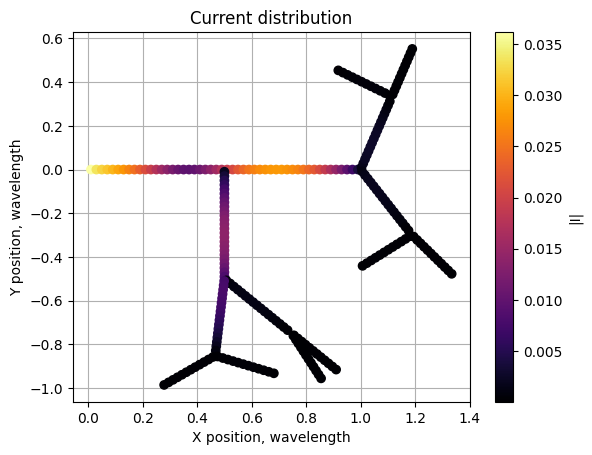

In [20]:
import geometry as gm
gm.plot_distribution(I,R,frequency)

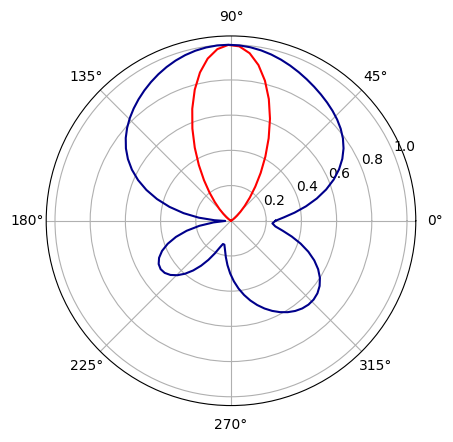

In [21]:
import matplotlib.pyplot as plt 
aim_func = np.zeros(len(angles))
for i in range(len(angles)):
    aim_func[i] = max(0, np.sin(angles[i])**7)
E = E / np.max(E)
plt.polar(angles,aim_func, c = 'r')
plt.polar(angles, E, c = 'darkblue')